In [1]:
from vegetation.preprocessing.ndvi_prep import remove_ndvi_outliers
import os 
import xarray as xr
from utils.function_clns import config
import logging
from vegetation.preprocessing.ndvi_prep import load_eumetsat_ndvi_max
from dask.diagnostics import ProgressBar
import pyproj
from vegetation.preprocessing.ndvi_prep import NDVIPreprocess


baseline_path = config["DEFAULT"]["local"] #config["NDVI"]["ndvi_path"]

os.environ['PROJ_LIB'] = pyproj.datadir.get_data_dir()

chunks={"time":-1, "lat":90, "lon":90}
filename = "seviri_full_image_smoothed.zarr"
ds_clean = xr.open_zarr(os.path.join(baseline_path, filename), 
                        chunks=chunks)
ds_clean["ndvi"] = remove_ndvi_outliers(ds_clean["ndvi"])

streaks_data = xr.open_zarr(os.path.join(
    baseline_path, 
    "mask_num_streaks.zarr"),
    chunks=chunks)

# Step 2: Calculate length of each streak
total_length = streaks_data.streaks.sum(dim='time')
num_streaks = streaks_data.streaks.count(dim='time')
days = len(streaks_data["time"])
max_strike = streaks_data.streaks.max(dim='time')

# Step 3: Calculate average
average_length = total_length / num_streaks
fraction_streaks = total_length/days

ds_clean["ndvi"] = ds_clean["ndvi"].where(streaks_data.quality_flag<=3)


filepath = os.path.join(baseline_path, "seviri_daily_ndvimax.nc")
max_ndvi = load_eumetsat_ndvi_max(filepath, 
                                  chunks=chunks)
# modis_ds = xr.open_zarr(os.path.join(config["MODIS"]["download"], "ndvi_daily_modis.zarr"),
#                         chunks= {"time":"auto", "lat":"auto", "lon":"auto"})

ds_ndvi = NDVIPreprocess(ds_clean["ndvi"]).get_processed_data()
max_ndvi = NDVIPreprocess(max_ndvi).get_processed_data()
# modis_ndvi = NDVIPreprocess(modis_ds["ndvi"]).get_processed_data()

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/abc.py:85: FutureWarning: xarray subclass XarrayWS should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 90. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 90. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 90. This co

In [2]:
from odc.geo.geobox import GeoBox
from typing import Union
from odc.geo import resyx_, wh_
from odc.geo.crs import CRS

def geobox_from_rio(xds: Union[xr.Dataset, xr.DataArray]) -> GeoBox:
    """This function retrieves the geobox using rioxarray extension.

    Parameters
    ----------
    xds: :obj:`xarray.DataArray` or :obj:`xarray.Dataset`
        The xarray dataset to get the geobox from.

    Returns
    -------
    :obj:`odc.geo.geobox.GeoBox`

    """
    height, width = xds.rio.shape
    try:
        transform = xds.rio.transform()
    except AttributeError:
        transform = xds[xds.rio.vars[0]].rio.transform()
    return GeoBox(
        shape=wh_(width, height),
        affine=transform,
        crs=CRS(xds.rio.crs.to_wkt()),
    )

In [21]:
def odc_reproject(ds, target_ds, resampling:str):
    from odc.geo.xr import xr_reproject
    if target_ds.odc.geobox.crs.geographic:
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
    return xr_reproject(ds, target_ds.odc.geobox, 
                        resampling=resampling, 
                        resolution="same")

In [55]:
from utils.function_clns import prepare, align_datasets, xesmf_regrid_align
import pandas as pd
from rasterio.enums import Resampling
chunks = {"time":-1, "lat":80, "lon":80}

geobox_eumetsat = geobox_from_rio(max_ndvi)

logging.info("Starting reprojecting...")
ds_repr_eu = odc_reproject(ds_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_eu["lat"] = max_ndvi["lat"]
ds_repr_eu["lon"] = max_ndvi["lon"]

ds1, ds2 = align_datasets(ds_repr_eu, max_ndvi, chunks=chunks)
logging.info("Succesfully reprojected our dataset")

ds_repr_mod = odc_reproject(modis_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_mod["lat"] = max_ndvi["lat"]
ds_repr_mod["lon"] = max_ndvi["lon"]

ds3, ds4 = align_datasets(ds_repr_mod, max_ndvi, chunks=chunks)
ds5, ds6 = align_datasets(ds_repr_mod, ds_repr_eu, chunks=chunks)

INFO:root:Starting reprojecting...


INFO:root:Succesfully reprojected our dataset


In [64]:
import xskillscore as xs

def print_metrics(corr, rmse, string1, string2):
    print(f"mean correlation between {string1} and {string2} is", corr.mean().values)
    print(f"mean rmse between {string1} and {string2} is", rmse.mean().values)
    # print(f"mean mae between {string1} and {string2} is", mae.mean().values)
    # print(f"mean mape between {string1} and {string2} is", mape.mean().values)

### Ours with EUMETSAT
with ProgressBar():
    # corr_a = xs.pearson_r(ds1, ds2, dim="time", skipna=True).load()
    # rmse_a = xs.rmse(ds1, ds2, dim="time", skipna=True).load()
    # # mae_a = xs.mae(ds1, ds2, dim="time", skipna=True)
    # # mape_a = xs.mape(ds1, ds2, dim="time", skipna=True)
    # print_metrics(corr_a, rmse_a,"OURS", "EUMETSAT")

    ### Ours with MODIS
    corr_b = xs.pearson_r(ds4, ds3, dim="time", skipna=True).load()
    rmse_b = xs.rmse(ds4, ds3, dim="time", skipna=True).load()
    # mae_b = xs.mae(ds4, ds3, dim="time", skipna=True)
    # mape_b = xs.mape(ds4, ds3, dim="time", skipna=True)
    print_metrics(corr_b, rmse_b,"OURS", "MODIS")

    ### EUMETSAT with MODIS
    corr_c = xs.pearson_r(ds5, ds6, dim="time", skipna=True).load()
    rmse_c = xs.rmse(ds5, ds6, dim="time", skipna=True).load()
    # mae_c = xs.mae(ds5, ds6, dim="time", skipna=True)
    # mape_c = xs.mape(ds5, ds6, dim="time", skipna=True)
    print_metrics(corr_c, rmse_c,"EUMETSAT", "MODIS")

[########################################] | 100% Completed | 52m 55s
[########################################] | 100% Completed | 50m 24s
mean correlation between OURS and MODIS is 0.49575216
mean rmse between OURS and MODIS is 0.12813774
[########################################] | 100% Completed | 2hr 39m
[########################################] | 100% Completed | 2hr 22m
mean correlation between EUMETSAT and MODIS is 0.42752737
mean rmse between EUMETSAT and MODIS is 0.12883358


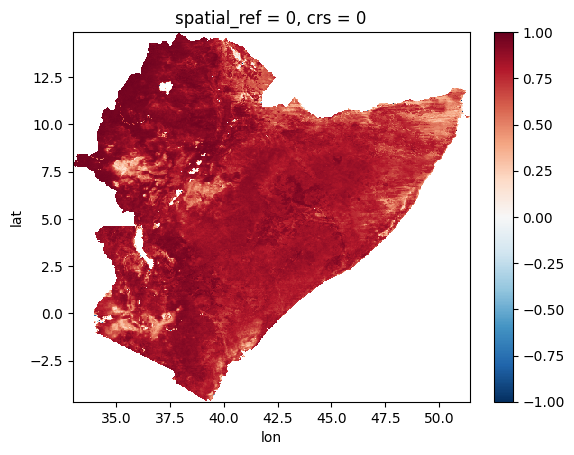

In [60]:
corr_a.plot()

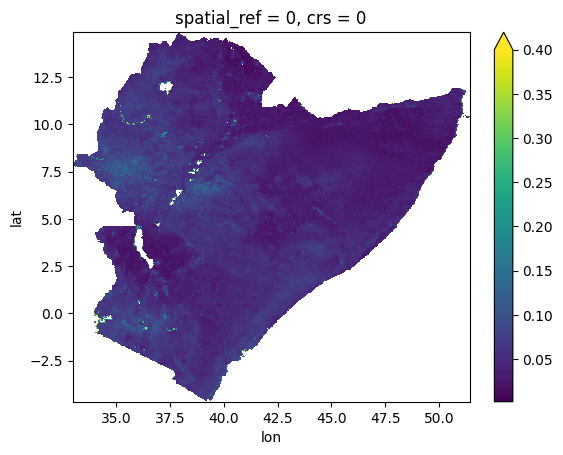

In [61]:
rmse_a.plot(vmax=0.4)

In [ ]:
# Extract predicted and real values
import numpy as np

predicted_values = ds5.values.flatten()
real_values = ds6.values.flatten()

arr1 = predicted_values[~np.isnan(predicted_values)]
arr2 = real_values[~np.isnan(real_values)]

In [ ]:
import matplotlib.pyplot as plt
# Create a hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(real_values, predicted_values, gridsize=50, bins='log', cmap='inferno')
plt.colorbar(label='Count in bin')
plt.title('Hexbin Plot of Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title("Scatterplot EUMETSAT and MODIS")
plt.grid(True)
plt.show()

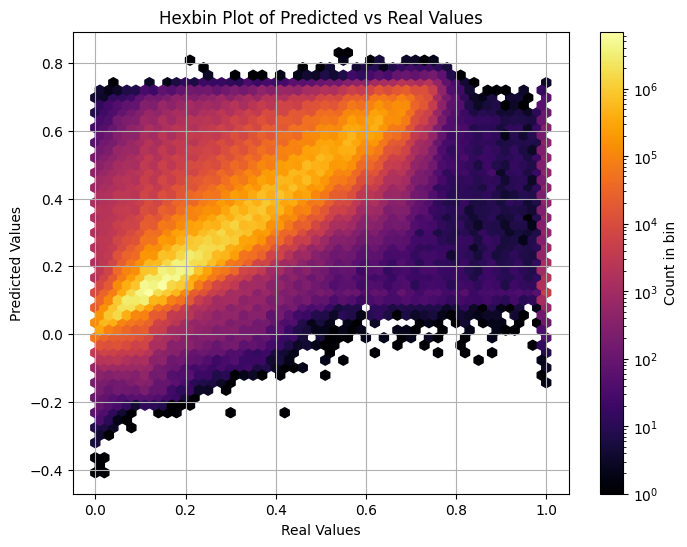

In [63]:
import matplotlib.pyplot as plt
# Create a hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(real_values, predicted_values, gridsize=50, bins='log', cmap='inferno')
plt.colorbar(label='Count in bin')
plt.title('Hexbin Plot of Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Autocorrelation

In [66]:
from esmtools.stats import autocorr

auto_ds1 = autocorr(ds1)

In [75]:
with ProgressBar():
    auto_ds1 = auto_ds1.load()

KeyboardInterrupt: 

### Cleaning NDVI due to clouds

In [ ]:
import os
from utils.function_clns import config, prepare, subsetting_pipeline
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

dataset = prepare(subsetting_pipeline( 
            xr.open_dataarray(os.path.join(config['NDVI']['ndvi_path'], 
            "ndvi_smoothed_w2s.nc")))).transpose("time","lon","lat")


In [ ]:
from vegetation.data_collection.ee_modis import EeModis
from utils.function_clns import config


start_date = "2018-08-17"
end_date = "2023-12-31"

modis_data = EeModis(start_date, end_date, name="ref_061")